In [2]:
#Nos conectamos al Google colab para poder realizar pruebas del modelo 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importación de las librerias necesarias para el proyecto
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.12.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Copiamos el repositorio de git para poder acceder al archivo .json de Kaggle y descargra el dataset
! git clone https://github.com/JuanSMontoyaF/ProcesamientoDatosSecuenciales.git

Cloning into 'ProcesamientoDatosSecuenciales'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 149 (delta 0), reused 0 (delta 0), pack-reused 147
Receiving objects: 100% (149/149), 1.66 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
#Instalamos Kaggle para acceder al dataset
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Creamos la carpeta donde guardaremos el dataset
!mkdir ~/.kaggle

In [7]:
#Copiamos el archivo .json a la carpeta de Kaggle
! cp '/content/ProcesamientoDatosSecuenciales/Entrega #2/kaggle.json' ~/.kaggle/

In [8]:
#Damos los permisos necesarios
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
#Descargamos el dataset
!kaggle datasets download kazanova/sentiment140/download?datasetVersionNumber=2

100% 80.9M/80.9M [00:00<00:00, 105MB/s]
100% 80.9M/80.9M [00:00<00:00, 98.3MB/s]


In [10]:
# Descomprimimos el dataset
! unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [11]:
#Se utiliza el dataset Sentiment-140 de Kaggle, contiene 1.6 millones de Tweets, lo que es ideal para el entrenamiento del modelo
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
#Asignamos nombres a las columnas del dataset, ya que tienen numeros
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
# Quitamos las columnas que no son necesarias y solo dejamos las de interés para la clasificación de textos (sentiment y text)
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [14]:
#Se asigna el sentimiento de positivo y negativo. 0 como Negativo y 1 como positivo
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Distribución de datos de opinión')

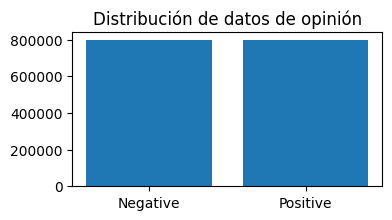

In [15]:
#Analizaremos el conjunto de datos por su distribución.
val_count = df.sentiment.value_counts()

plt.figure(figsize=(4,2))
plt.bar(val_count.index, val_count.values)
plt.title("Distribución de datos de opinión")

In [16]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] #crea índices aleatorios para elegir del marco de datos
df.loc[random_idx_list,:].head(10) # Devuelve las filas con el índice y lo muestra

,sentiment,text
1479922,Positive,About to show my tattoo in the contest in rich...
978325,Positive,Just got back from Numen's Bonfire. I was goi...
753945,Negative,@hollabitch constant blocked nose for me too ...
28895,Negative,nothin bored xx
1451227,Positive,"Thank you, kelly manson brideway. Good luck. ..."
924358,Positive,is so happy to be back at church&amp;to be you...
1382797,Positive,@Bonniestwit @dianaroua @VCasal @tap29 Th...
1137330,Positive,@Leanne0710 thanks your a star my dear x
1272649,Positive,"rejoice Splinter Cell fans, Sam Fisher is back..."
88689,Negative,My bestfriend's getting addicted to Facebook's...


## Procesamiento de los textos
* Se tienen en los textos muchos signos y palabras que no son importantes para la clasificación, por ello hay que eliminarlos. Estos textos son tweets, por lo que tienen muchos enlaces, emojis o puntuaciones
* Hay palabras que tienen formas derivadas, por ejemplo formaliti -> formality, y hay palabras que tienen significados muy parecidos para ello se utiliza el Steamming (Derivación) y Lemantization(Lemantización) para reducir esto

* En twitter se mencionan muchas personas en videos de esta forma: @arunrk7, @andrewng

In [17]:
#Utilizamos la librería NLTK que tiene herramientas para el procesamiento de textos
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [18]:
#La función "preprocess" toma un texto como entrada, realiza operaciones de limpieza y 
#preprocesamiento básicas, y devuelve el texto preprocesado con la opción de aplicar 
#stemming para reducir las palabras a su forma raíz.
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [19]:
df.text = df.text.apply(lambda x: preprocess(x))

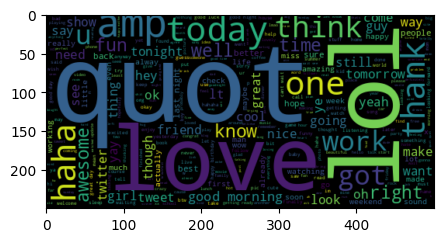

In [20]:
#Palabras positivas
from wordcloud import WordCloud

plt.figure(figsize = (5,5)) 
wc = WordCloud(max_words = 500 , width = 500 , height = 250).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

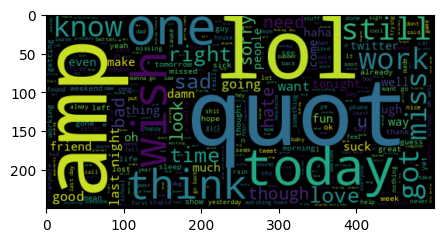

In [21]:
#Palabras negativas
plt.figure(figsize = (5,5)) 
wc = WordCloud(max_words = 500 , width = 500 , height = 250).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Dividimos el conjunto de datos

In [22]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [23]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,random_state=7) # Divide el conjunto de datos en entrenamiento y prueba
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [24]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


## Tokenization
* Esto nos ayudará a cortar en pedazos el texto, por ejemplo "Hello how are you" en Hello/how/are/you


In [25]:
from keras.preprocessing.text import Tokenizer
#tokenizer crea tokens para cada palabra en el corpus de datos y los asigna a un índice usando el diccionario.
#word_index contiene el índice de cada palabra
#vocab_size representa el número total de palabras en el corpus de datos

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [26]:
#Ahora tenemos un objeto tokenizador, que se puede usar para convertir cualquier palabra en una clave en el diccionario (número).
#Hay que alimentar al modelo con una secuencia de números.Todo debe ser de la misma longitud. 
#Pero los textos en los tweets tienen diferentes recuentos de palabras. pad_sequence hará toda la secuencia en una longitud constante MAX_SEQUENCE_LENGTH

from keras.utils import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [27]:
labels = train_data.sentiment.unique().tolist()

In [28]:
#el modelo va a predecir una clase codificada (0 o 1). Se codifican las etiquetas de entrenamiento 
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Word Emdedding
* Se ha utilizado el diccionario de Standford para la incrustación de palabras y dar más sentido a las oraciones

In [29]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip        

--2023-06-05 13:40:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-05 13:40:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-05 13:40:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [30]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [31]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [32]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [33]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Entrenamiento del modelo - LSTM (Long Short-Term Memory)

* Arquitectura de red neuronal recurrente (RNN) variante de las redes neuronales recurrentes que utiliza unidades de memoria especializadas para capturar dependencias a largo plazo en secuencias de datos

In [34]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

1) Embedding Layer 

2) Conv1D Layer 

3) LSTM - Long Short Term Memory

4) Dense

In [35]:
#Este código define una arquitectura de red neuronal para la clasificación de texto utilizando 
#una combinación de capas convolucionales, LSTM bidireccional y capas densas. El modelo se entrena para 
#clasificar secuencias de texto en dos categorías y se espera que produzca una salida de probabilidad 
#de pertenencia a la clase positiva o negativa.

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           87172500  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

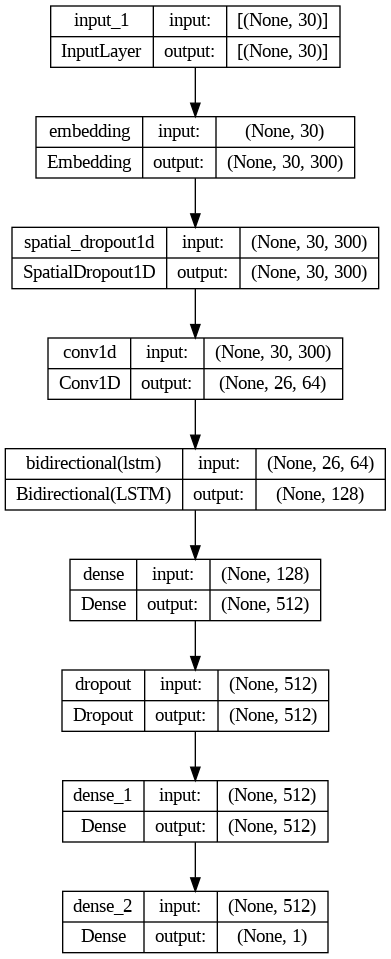

In [36]:
#Cálculo de las capas
from tensorflow import keras
model.summary()
#(5 * 300 + 1) * 64 = 96064
#(4 * 64 + 64^2) * 2 = 65,536

keras.utils.plot_model(model, to_file='modelo1.png', show_shapes=True, show_layer_names=True)

# Optimización del modelo

Callbacks
Las devoluciones de llamada son funciones especiales que se llaman al final de una época. Podemos usar cualquier función para realizar una operación específica después de cada época. Usé dos devoluciones de llamada aquí,

LRScheduler: cambia una tasa de aprendizaje en una época específica para lograr un mejor resultado

ModelCheckPoint: guarda el mejor modelo durante el entrenamiento

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)                    

In [38]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])               

Epoch 1/10
1250/1250 [==============================] - 171s 123ms/step - loss: 0.5179 - accuracy: 0.7403 - val_loss: 0.4825 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 148s 118ms/step - loss: 0.4871 - accuracy: 0.7628 - val_loss: 0.4713 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 141s 113ms/step - loss: 0.4770 - accuracy: 0.7693 - val_loss: 0.4675 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 138s 110ms/step - loss: 0.4708 - accuracy: 0.7733 - val_loss: 0.4640 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 145s 116ms/step - loss: 0.4664 - accuracy: 0.7763 - val_loss: 0.4634 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 152s 122ms/step - loss: 0.4634 - accuracy: 0.7777 - val_loss: 0.4595 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 7/10
1250/1250 [============

In [39]:
model.save('modelo_texto.h5')

## Evaluación del modelo

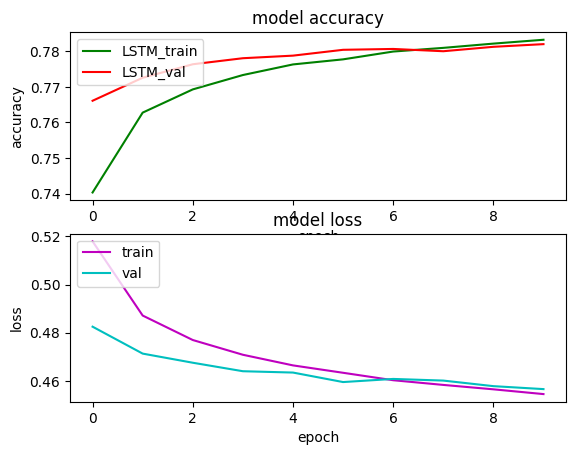

In [40]:
#Curva de aprendizaje y pérdida
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'g')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [41]:
#Se establece como umbral el 0.5, por lo que si en la predicción el valor está por encima de esto se clasificará como positivo
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 66ms/step


## Matriz de confusión

In [42]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

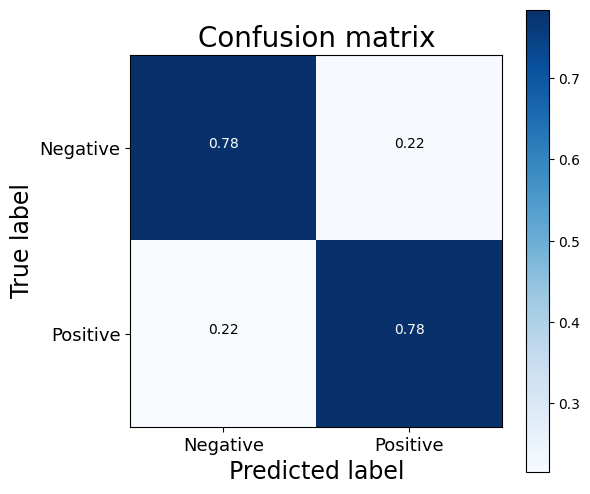

In [43]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [44]:
print(classification_report(list(test_data.sentiment), y_pred_1d))


              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78    160542
    Positive       0.78      0.78      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



## Pruebas

In [45]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/modelo_texto.h5')

In [46]:
def preprocess_text(text):
    # Preprocess the text (similar to the preprocessing done on the training data)
    processed_text = preprocess(text)
    # Tokenize the processed text
    sequence = tokenizer.texts_to_sequences([processed_text])
    # Pad the sequence to the same length as the training data
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    return padded_sequence

def predict_sentiment(text):
    processed_text = preprocess_text(text)
    # Make the prediction using the loaded model
    prediction = model.predict(processed_text)
    # Decode the predicted sentiment
    sentiment = decode_sentiment(prediction[0])
    return sentiment

# Example usage:
text = "This is a good movie!"
sentiment = predict_sentiment(text)
print("Sentiment:", sentiment)


1/1 [==============================] - 1s 735ms/step
Sentiment: Positive


#Entrenamiento del modelo - TRANSFORMERS BERT


In [47]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.7 MB/s eta 0:00:00


In [48]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [49]:
import pandas as pd
import numpy as np

file = "/content/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file, encoding='ISO-8859-1', usecols=[0,5], header=None)\
        .sample(frac=0.01, random_state=42)

df.columns = ['label','sentence']
df.label = df.label.apply(lambda x: np.float64(1) if x==4 else np.float64(x))

print("df.shape =",df.shape)
print(f"label distribution :\n{df.label.value_counts()}")
print(df.head())

df.shape = (16000, 2)
label distribution :
1.0    8018
0.0    7982
Name: label, dtype: int64
        label                                           sentence
541200    0.0             @chrishasboobs AHHH I HOPE YOUR OK!!! 
750       0.0  @misstoriblack cool , i have no tweet apps  fo...
766711    0.0  @TiannaChaos i know  just family drama. its la...
285055    0.0  School email won't open  and I have geography ...
705995    0.0                             upper airways problem 


In [50]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint, output_hidden_states=True)
clear_output()

In [51]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

sequences, test_val_sequences = train_test_split(df, test_size=0.3,
                                             stratify=df.label, random_state=44)
val_sequences, test_sequences = train_test_split(test_val_sequences, test_size=0.7,
                                             stratify=test_val_sequences.label, random_state=44)
dataset = {
    "ENTRENAMIENTO": sequences['sentence'].values.tolist(),
    "PRUEBA": test_sequences['sentence'].values.tolist(),
    "VALIDACION": val_sequences['sentence'].values.tolist()
}
targets = {
    "ENTRENAMIENTO": sequences['label'].values.tolist(),
    "PRUEBA": test_sequences['label'].values.tolist(),
    "VALIDACION": val_sequences['label'].values.tolist()
}

In [52]:
def tokenization(data, **kwargs):
    return tokenizer(data, 
                   padding=kwargs.get('padding','longest'), 
                   max_length=kwargs.get('max_length',55),
                   truncation=True, 
                   return_tensors="tf")

In [53]:
def get_model(**kwargs):
    max_seq_length = kwargs.get('max_seq_length',55)

    input_ids = tf.keras.Input(shape=(max_seq_length,),dtype='int32')
    attention_mask = tf.keras.Input(shape=(max_seq_length,),dtype='int32')

    transformer = model({'input_ids':input_ids, 'attention_mask':attention_mask}, 
                        training=False)    
    pooler_output  = transformer["pooler_output"] 

    # Model Head
    h1 = tf.keras.layers.Dense(128, activation='relu')(pooler_output)
    dropout = tf.keras.layers.Dropout(0.2)(h1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

    new_model = tf.keras.models.Model(inputs = [input_ids, attention_mask], 
                                      outputs = output)
    new_model.compile(tf.keras.optimizers.Adam(lr=1e-4), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

    return new_model


In [54]:
from sklearn.metrics import classification_report

def test_result(model):    
    test_inputs = tokenization(dataset["PRUEBA"])
    result_proba = model.predict([test_inputs.input_ids, test_inputs.attention_mask])
    result = [1 if x>0.5 else 0 for x in result_proba.ravel()]
    print(classification_report(targets['PRUEBA'],result))
    return result_proba, result

In [57]:
new_model = get_model()
result_proba_before, result_before = test_result(new_model)

105/105 [==============================] - 14s 110ms/step
              precision    recall  f1-score   support

         0.0       0.49      0.91      0.64      1677
         1.0       0.44      0.07      0.12      1683

    accuracy                           0.49      3360
   macro avg       0.47      0.49      0.38      3360
weighted avg       0.47      0.49      0.38      3360



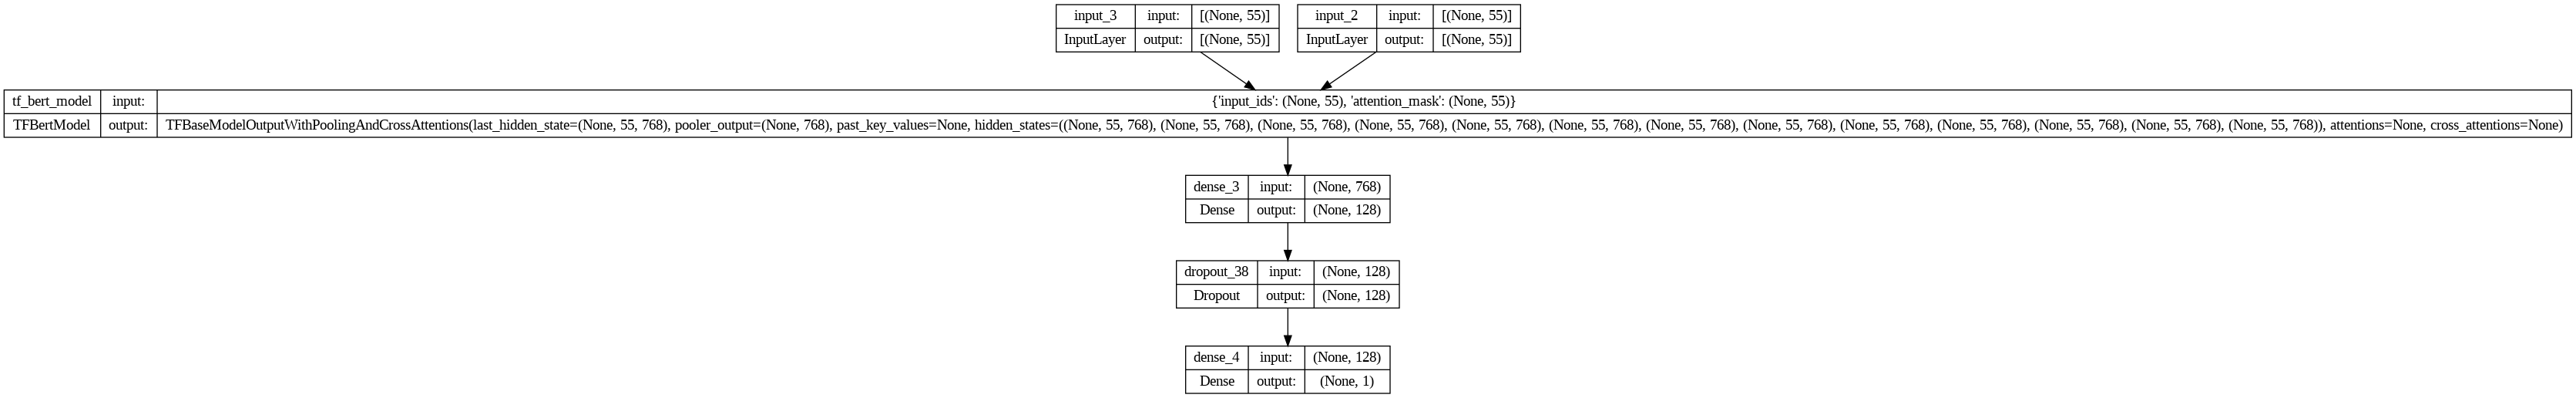

In [58]:
keras.utils.plot_model(new_model, to_file='modeloTransformers.png', show_shapes=True, show_layer_names=True)

In [59]:
inputs = tokenization(dataset['ENTRENAMIENTO'])
train_targets = tf.convert_to_tensor(targets['ENTRENAMIENTO'])

val_inputs = tokenization(dataset['VALIDACION'])
val_targets = tf.convert_to_tensor(targets['VALIDACION'])

new_model.fit([inputs.input_ids, inputs.attention_mask], train_targets, 
              validation_data = ([val_inputs.input_ids, val_inputs.attention_mask], val_targets),
              epochs=10, batch_size=64)  

Epoch 1/10
175/175 [==============================] - 167s 713ms/step - loss: 0.7503 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 2/10
175/175 [==============================] - 119s 677ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4986
Epoch 3/10
175/175 [==============================] - 116s 663ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4986
Epoch 4/10
175/175 [==============================] - 115s 659ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 5/10
175/175 [==============================] - 115s 659ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 6/10
175/175 [==============================] - 115s 659ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 7/10
175/175 [==============================] - 115s 659ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 -

In [60]:
result_proba_after, result_after = test_result(new_model)

105/105 [==============================] - 11s 105ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1677
         1.0       0.50      1.00      0.67      1683

    accuracy                           0.50      3360
   macro avg       0.25      0.50      0.33      3360
weighted avg       0.25      0.50      0.33      3360

